![banner cnns ppgcc ufsc](http://www.lapix.ufsc.br/wp-content/uploads/2019/04/VC2.png)



<a href="https://colab.research.google.com/drive/1bnZKt0ROKOrIlE3LPamhSTqh4xZNR_Y1"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Python-v.3.7-green.png" alt="Python Version" title="Python Version"></a>

### Info on Jupyter Notebooks

Look here: 
 * [LAPIX::Jupyter Notebooks na UFSC (Seminário para Professores do INE2019.1)](http://www.lapix.ufsc.br/jupyter-notebooks-na-ufsc/)
 * [LAPIX::Como Importar Jupyter Notebooks de GitHub para Google Colab?](http://www.lapix.ufsc.br/ensino/como-importar-jupyter-notebooks-de-github-para-google-colab/)

# Initializations

### Checking where you're running...

In [1]:
!uname -a
!cat /etc/lsb-release

Linux note 4.15.0-58-generic #64~16.04.1-Ubuntu SMP Wed Aug 7 14:10:35 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=16.04
DISTRIB_CODENAME=xenial
DISTRIB_DESCRIPTION="Ubuntu 16.04.6 LTS"


### Cloning the ***Computer Vision*** repository from a Git

If you're running this at your computer or using Google Colab but **not** using your Google Drive, this is the way to use these notebooks!

In [ ]:
# To clone from our personal Github mirror (may be out of sync):
!git clone https://github.com/awangenh/vision

In [ ]:
# To clone from UFSC's Institutional Gitlab (always the latest version):
!git clone https://codigos.ufsc.br/aldo.vw/vision

### Mount your Google Drive as a Folder

If you're using Google Colab together with your Google Drive, adapt this code below to point to the place where you've copied our Git in your Google Drive:

In [ ]:
# Code to mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Look at the contents of your Drive:

In [ ]:
!ln -s "/content/drive/My Drive"

### Common Initializations

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Example in the Domain of Values: Simple Car Detector

## 1. Naïve Approach

### Initialize and load first image: Street with Cars

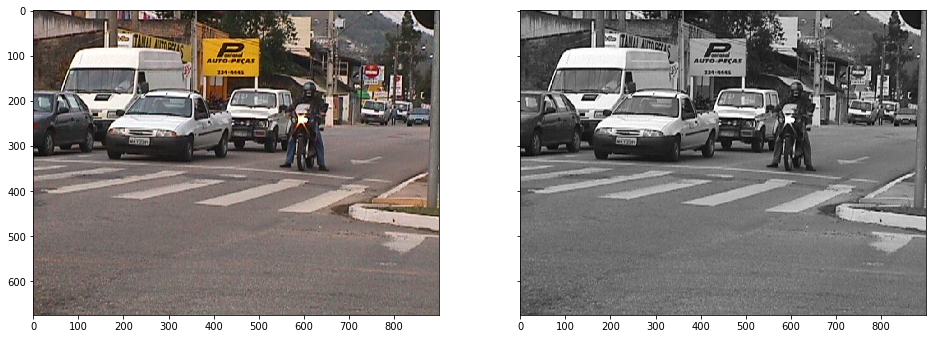

In [3]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

# Load the image in color (OpenCV standard = BGR)
orig = cv2.imread("../data/street-01.jpg", cv2.IMREAD_COLOR)
# Convert to RGB
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# Load the image in grayscale
gray = cv2.imread("../data/street-01.jpg", cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(orig)
ax[1].imshow(gray, 'gray')

### Load a Reference Image

The simplest strategy, used in CCTV cameras, is to compare frames to a reference image. This image does not need to be static, it can be automatically updated always when nothing happens for a long time...

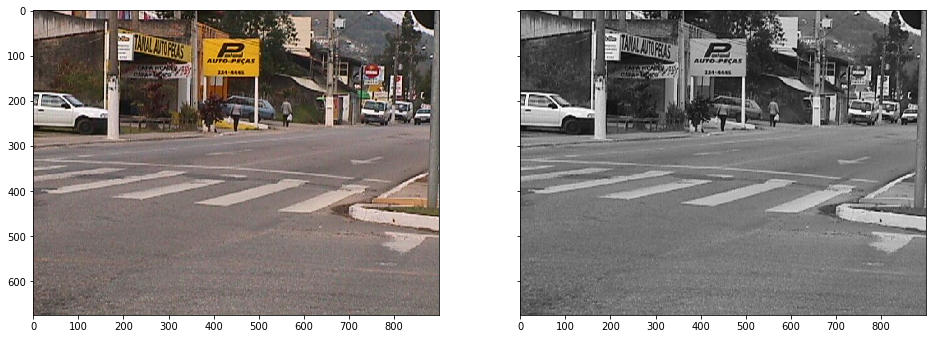

In [12]:
# Load the image in color (OpenCV standard = BGR)
ref_orig = cv2.imread("../data/street-00.jpg", cv2.IMREAD_COLOR)
# Convert to RGB
ref_orig = cv2.cvtColor(ref_orig, cv2.COLOR_BGR2RGB)

# Load the image in grayscale
ref_gray = cv2.imread("../data/street-00.jpg", cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(ref_orig)
ax[1].imshow(ref_gray, 'gray')

Why ax[1].imshow(ref_gray, 'gray') ?

Look at: [Matplotlib colormaps](https://matplotlib.org/examples/color/colormaps_reference.html)

### What has changed? Absolute Differences

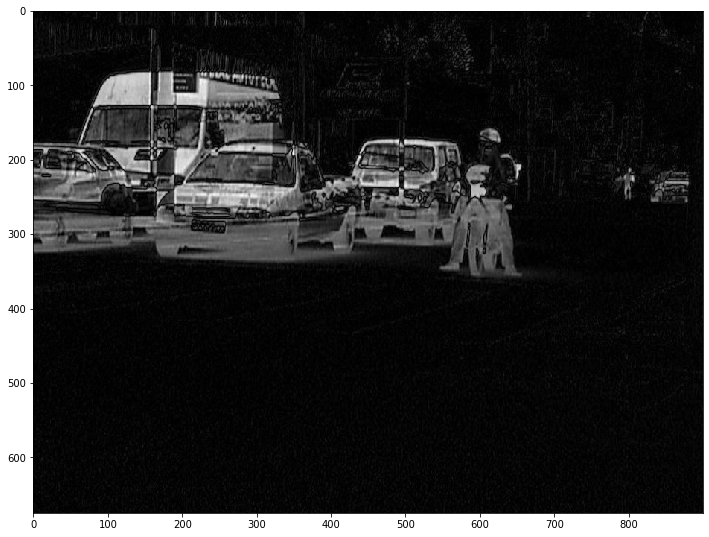

In [5]:
# Calculate the absolute difference between two images
# Image order is irrelevant since we will discard the sign
change = cv2.absdiff(gray, ref_gray)
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(change, 'gray')

### Simple Thresholds in OpenCV

In [6]:
modes = ['cv2.THRESH_BINARY',
         'cv2.THRESH_BINARY_INV',
         'cv2.THRESH_TRUNC',
         'cv2.THRESH_TOZERO',
         'cv2.THRESH_TOZERO_INV']

# Basic threshold example
def my_threshold(thresh, modeStr):
    global change
    global dst
    mode = eval(modeStr)
    th, dst = cv2.threshold(change, thresh, 255, mode)
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(change,'gray')
    ax[1].imshow(dst,'gray')

# Pass function & its parameters to interactive
interactive(my_threshold, thresh = (0, 255), modeStr=modes)

# If your using Google Colab, comment the line above and use this here...
# my_threshold(25, 'cv2.THRESH_BINARY')

interactive(children=(IntSlider(value=127, description='thresh', max=255), Dropdown(description='modeStr', opt…

### Extract the original Pixels of what you've found: Image Multiplication

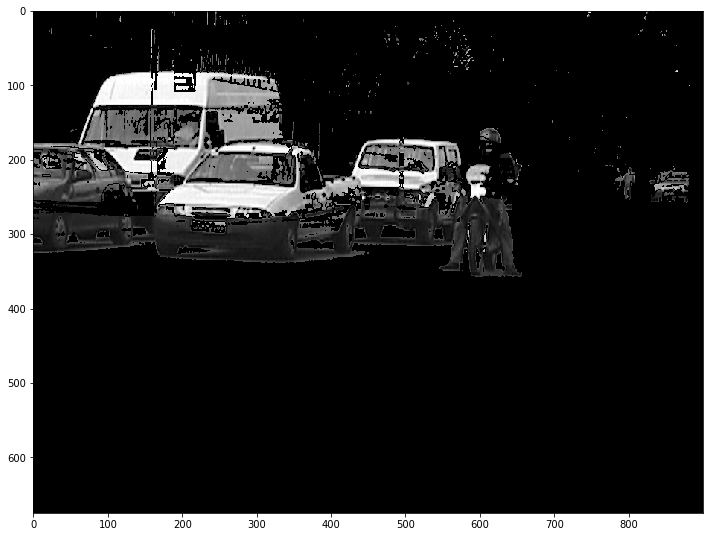

In [7]:
masked = cv2.multiply(gray, (dst//255))
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(masked, 'gray')

## 2. Refining

The result above is not good. Let's refine it using a few methods from the Domain of Space. We will employ Mathematical Morphology:
- https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

### Dilation and Erosion, Opening and Closing

First you'll need a *kernel*. A simple kernel can be a square:

In [73]:
kernel = np.ones((5,5),np.uint8)
kernel

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

You can also use more advanced kernel functions from OpenCV:

In [72]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
kernel

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

We'll go directly to the composite operations **Opening and Closing**. Later, in the lecture about *Morphology* we will talk about **Eroding and Dilating**:

### *Open* the Mask with your Kernel

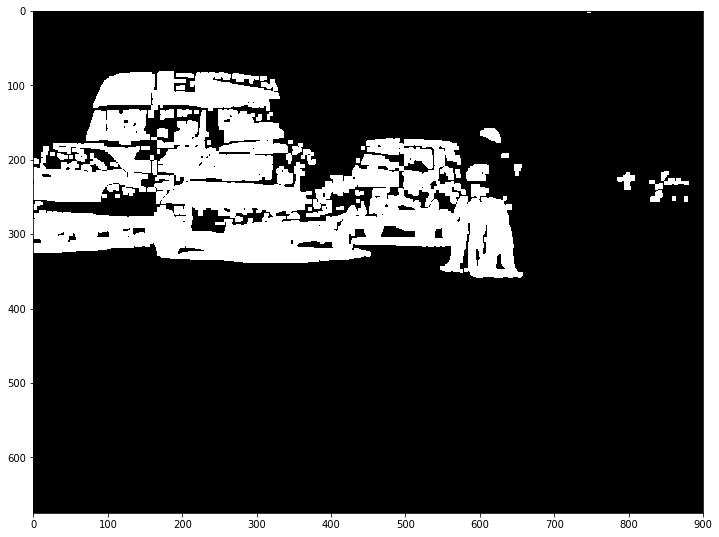

In [78]:
opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(opening, 'gray')

### *Close* the openend Mask with your Kernel

In [87]:
kernel2 = np.ones((25,25),np.uint8)
kernel2

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
      

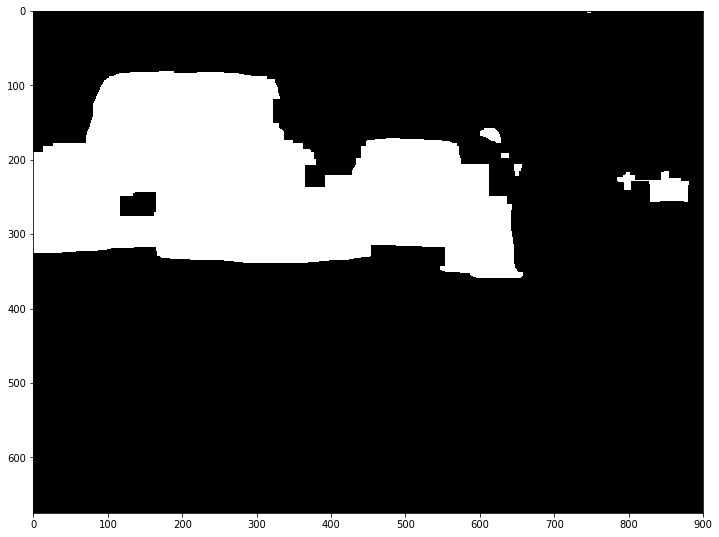

In [88]:
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(closing, 'gray')

### Apply it again to your image

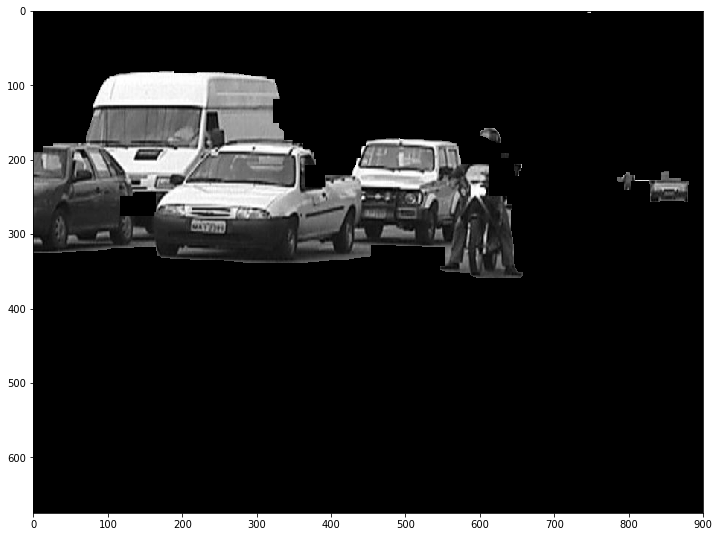

In [89]:
masked_with_morpho = cv2.multiply(gray, (closing//255))
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(masked_with_morpho, 'gray')

# Other Functions

### Adaptive Thresholds in OpenCV

In [76]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

modes = ['cv2.THRESH_BINARY',
         'cv2.THRESH_BINARY_INV',
         'cv2.THRESH_TRUNC',
         'cv2.THRESH_TOZERO',
         'cv2.THRESH_TOZERO_INV']

adaptModes = ['cv2.ADAPTIVE_THRESH_MEAN_C',
              'cv2.ADAPTIVE_THRESH_GAUSSIAN_C']

# Set the figure size, remembering that matplotlib 
# uses INCHES and not pixels...
matplotlib.rcParams['figure.figsize'] = [8,8]
 
# Read image
src = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)
  
# Basic threshold example
def my_adaptThreshold(adaptModeStr, modeStr, neighborhood):
    global src
    mode = eval(modeStr)
    adaptMode = eval(adaptModeStr)
    dst = cv2.adaptiveThreshold(src, 255, adaptMode, mode, neighborhood, 10)
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(src,'gray')
    ax[1].imshow(dst,'gray')

# Pass function & its parameters to interactive
interactive(my_adaptThreshold, adaptModeStr=adaptModes, modeStr=modes, neighborhood=(3,31,2))



interactive(children=(Dropdown(description='adaptModeStr', options=('cv2.ADAPTIVE_THRESH_MEAN_C', 'cv2.ADAPTIV…

### Adaptive Thresholds in SciKit

SciKit only can do mean-based adaptive thresholding. 

What is SciPy and what are SciKits in Python?
 * [SciPy is a Python-based ecosystem of open-source software for mathematics, science, and engineering](https://www.scipy.org/)
 * [SciPy Toolkits are add-on packages for SciPy](https://www.scipy.org/scikits.html)
   * [scikit-image is a collection of algorithms for image processing](https://scikit-image.org/)
   * [scikit-learn are sSimple and efficient tools for data mining and data analysis](https://scikit-learn.org/stable/)

In [13]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_local
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

image = data.page()
# Read image
# image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)



block_size = 35

# Basic threshold example
def my_scikitAdaptThreshold(neighborhood):
    global image
    
    global_thresh = threshold_otsu(image)
    binary_global = image > global_thresh

    binary_adaptive = threshold_local(image, neighborhood, offset=10)

    fig, axes = plt.subplots(ncols=3, figsize=(20, 8))
    ax0, ax1, ax2 = axes
    plt.gray()

    ax0.imshow(image)
    ax0.set_title('Image')

    ax1.imshow(binary_global)
    ax1.set_title('Global thresholding')

    ax2.imshow(binary_adaptive)
    ax2.set_title('Adaptive thresholding')

    for ax in axes:
        ax.axis('off')

    plt.show()
    
# Pass function & its parameters to interactive
interactive(my_scikitAdaptThreshold, neighborhood=(3,31,2))

interactive(children=(IntSlider(value=17, description='neighborhood', max=31, min=3, step=2), Output()), _dom_…

## Histogram Thresholds

### Histogram Thresholds in SciKit #1: Bimodal based upon the Global Minimum

For pictures with a bimodal histogram, more specific algorithms can be used.
For instance, the minimum algorithm takes a histogram of the image and smooths it
repeatedly until there are only two peaks in the histogram.


In [64]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_minimum
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual


image = data.camera()

def my_histo_threshold(bins):
    global image

    thresh_min = threshold_minimum(image, bins)
    binary_min = image > thresh_min

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0, 0].imshow(image, cmap=plt.cm.gray)
    ax[0, 0].set_title('Original')

    ax[0, 1].hist(image.ravel(), bins=bins)
    ax[0, 1].set_title('Histogram')

    ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
    ax[1, 0].set_title('Thresholded (min)')

    ax[1, 1].hist(image.ravel(), bins=bins)
    ax[1, 1].axvline(thresh_min, color='r')

    for a in ax[:, 0]:
        a.axis('off')
    plt.show()
    
# Pass function & its parameters to interactive
interact_manual(my_histo_threshold, bins=(2, 256))

interactive(children=(IntSlider(value=129, description='bins', max=256, min=2), Button(description='Run Intera…

<function __main__.my_histo_threshold(bins)>

### Histogram Thresholds in SciKit #2: Bimodal based upon the Otsu's and a Collection of other Methods

Otsu's method [1] calculates an "optimal" threshold (marked by a red line in the histogram below) performing a Cluster Analysis that maximizes the variance between two classes of pixels, which are separated by the threshold. Equivalently, clustering method minimizes the intra-class variance.

.. [1] http://en.wikipedia.org/wiki/Otsu's_method


In [71]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_yen, threshold_isodata, threshold_li, threshold_triangle
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

methods = [
    'threshold_otsu(image, bins)',
    'threshold_yen(image, bins)',
    'threshold_isodata(image, bins)',
    'threshold_li(image)',
    'threshold_triangle(image, bins)']

image = data.camera()
# Read image
# image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)

def my_potpourri(method, bins):
    global image
    
    # Eval it!
    thresh = eval(method)
    # Generate a binary image 
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=bins)
    ax[1].set_title('Histogram '+str(bins))
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded: '+ method)
    ax[2].axis('off')

    plt.show()
    
# Pass function & its parameters to interactive
interact_manual(my_potpourri, method=methods, bins=(2, 256))

interactive(children=(Dropdown(description='method', options=('threshold_otsu(image, bins)', 'threshold_yen(im…

<function __main__.my_potpourri(method, bins)>

# Credits

* The OpenCV grayscale threshold examples were adapted from the following material:
  * https://www.learnopencv.com/opencv-threshold-python-cpp/
  * https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
* The SciKit grayscale threshold examples were adapted from the following materail:
  * https://scikit-image.org/docs/0.12.x/auto_examples/segmentation/plot_threshold_adaptive.html
  * https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_thresholding.html

![banner cnns ppgcc ufsc](http://www.lapix.ufsc.br/wp-content/uploads/2019/04/CC-incod.png)
